In [3]:
import os
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
import datetime
import configparser

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import lidar_processor, era5_processor

plt.style.use('latex_default.mplstyle')

"""Constants"""
# omega = 7.292*10**(-5)
g = 9.80665
Rd = 287.06
cp = 3.5 * Rd
Re = 6371229 # m (Radius of Earth for GRIB2 format - applies to ERA5 on ML)
p0 = 101325

cap=Rd/cp
capi=1/cap
capp=1.-cap # Cv/Cp
cappi=1./capp # Cp/Cv
wexnr=Rd/(cp-Rd) # Rd/Cv
compri=Rd/p0**cap
# th00=tt00*(pr00/pref00)**(-cap)
# rh00=pr00/(rg*tt00)

In [2]:
"""Interpolate ERA5 data to regular grid"""
# file_T21 = "../data/eulag/era5_ml_T21.nc"
# file_T21_int = "../data/eulag/era5_ml_T21_int.nc"
# era5_processor.prepare_T21(file_T21, file_T21_int)

'Interpolate ERA5 data to regular grid'

In [84]:
def tf(zeta):
    return zeta*zeta*zeta*(10.-15.*zeta+6.*zeta*zeta)
def tfd(zeta):
    return 30.*zeta*zeta*(1.-2.*zeta+zeta*zeta)

ds = xr.open_dataset("../data/eulag/era5_ml_T21_int.nc")
# ds = xr.open_dataset("../data/coral/era5-region/20180618-1644-ml-int.nc")

ds['th']  = ds['t'] * (p0/ds['p'])**(2/7)
ds['rho'] = ds['p']**capp / (ds['th']*compri)
# ppe(i,j,k)=(rhe(i,j,k)*the(i,j,k)*compri)**cappi

ds['N'] = (['time','level','latitude','longitude'], (g/ds['th'].values * np.gradient(ds['th'].values, ds['level'].values[1]-ds['level'].values[0], axis=1))**(1/2))
# i = np.arange(0,len(ds['level'])-1,1)
# logth = np.log(ds['th'].values)
# ds['N'] = (['time','level','latitude','longitude'], (g * np.gradient(logth, 400, axis=1))**(1/2))
# ds['N'][:,i,:,:] = (g * (logth[:,i+1,:,:]-logth[:,i,:,:]) / 400)**(1/2)

# ds = ds.drop(["t","p"])

"""Average and trim"""
dsm = ds.mean(dim=["time","latitude","longitude"])
ds = ds.mean(dim=["latitude","longitude"])

"""Pad profiles at upper boundary"""
icut = 140
npad = 110
vres = ds['level'].values[1]-ds['level'].values[0]
u  = np.concatenate((dsm['u'].values[:icut+1], dsm['u'].values[icut] * np.ones(npad)))
v  = np.concatenate((dsm['v'].values[:icut+1], dsm['v'].values[icut] * np.ones(npad)))

levels = np.arange(0, len(v)*vres, vres)
levels_pad= levels[-npad:]
print("Array legth: ", len(levels), "Max Alt: ", levels[-1])

zeta = (levels-levels[icut])/(levels[-1]-levels[icut])
u = np.where(levels>levels[icut], u-1.5*u*tf(zeta) , u)

coefficients_th = np.polyfit(ds['level'].values[-30:], dsm['th'].values[-30:], 2)
th_pad = np.polyval(coefficients_th, levels_pad)
th = np.concatenate((dsm['th'].values[:icut+1], th_pad))
N  = (g/th * np.gradient(th, vres))**(1/2)

coefficients_rho = np.polyfit(ds['level'].values[-30:], dsm['rho'].values[-30:], 2)
rho_pad = np.polyval(coefficients_rho, levels_pad)
rho = np.concatenate((dsm['rho'].values[:icut+1], rho_pad))

/tmp/ipykernel_29802/2428225435.py:13: RuntimeWarning: invalid value encountered in sqrt
  ds['N'] = (['time','level','latitude','longitude'], (g/ds['th'].values * np.gradient(ds['th'].values, ds['level'].values[1]-ds['level'].values[0], axis=1))**(1/2))


Array legth:  251 Max Alt:  100000.0


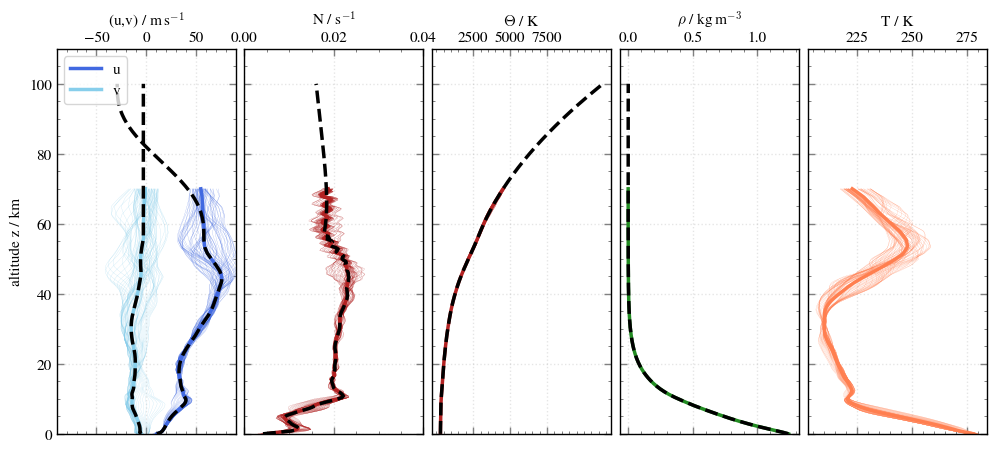

In [85]:
"""Vis env"""
# fig, ax = plt.subplots(1,1, figsize=(6,6), subplot_kw={'projection': ccrs.LambertConformal()})
fig, axes = plt.subplots(1,5, figsize=(12,5),sharey=True, gridspec_kw={"wspace": 0.05, "hspace": 0.05})
ax_wind  = axes[0]
ax_n     = axes[1]
ax_th    = axes[2]
ax_rho   = axes[3]
ax_t     = axes[4]

# ax.set_aspect("equal", adjustable='datalim')
"""Wind"""
lws = 0.1
lwl = 2.5
for t in range(len(ds.time)):
    ax_wind.plot(ds["u"][t], ds["level"]/1000, lw=lws, color="royalblue")
    ax_wind.plot(ds["v"][t], ds["level"]/1000, lw=lws, color="skyblue")
ax_wind.plot(dsm["u"], dsm["level"]/1000, lw=lwl, color="royalblue", label="u")
ax_wind.plot(dsm["v"], dsm["level"]/1000, lw=lwl, color="skyblue", label="v")
ax_wind.plot(u, levels/1000, lw=lwl, ls='--', color="black")
ax_wind.plot(v, levels/1000, lw=lwl, ls='--', color="black")
ax_wind.legend(loc="upper left")

ax_wind.set_xlabel("(u,v) / m$\,$s$^{-1}$")
ax_wind.set_ylabel("altitude z / km")
ax_wind.set_xlim([-90,90])
ax_wind.set_ylim([0,110])
ax_wind.xaxis.set_label_position('top')
ax_wind.xaxis.set_minor_locator(AutoMinorLocator())
ax_wind.yaxis.set_minor_locator(AutoMinorLocator())
ax_wind.tick_params(which='both', top=True, right= True, bottom=True, left=True, labelbottom=False,labeltop=True, color="grey")
ax_wind.grid()


"""N"""
for t in range(len(ds.time)):
    ax_n.plot(ds["N"][t], ds["level"]/1000, lw=lws, color="firebrick")
ax_n.plot(dsm["N"], dsm["level"]/1000, lw=lwl, color="firebrick")
ax_n.plot(N, levels/1000, lw=lwl, ls='--', color="black")
ax_n.set_xlabel("N / s$^{-1}$")
ax_n.set_xlim([0,0.04])

ax_n.xaxis.set_label_position('top')
ax_n.xaxis.set_minor_locator(AutoMinorLocator())
ax_n.yaxis.set_minor_locator(AutoMinorLocator())
ax_n.tick_params(which='both', top=True, right= True, bottom=True, left=True, labelbottom=False,labeltop=True, color="grey")
ax_n.grid()

"""Theta"""
for t in range(len(ds.time)):
    ax_th.plot(ds["th"][t], ds["level"]/1000, lw=lws, color="firebrick")
ax_th.plot(dsm["th"], dsm["level"]/1000, lw=lwl, color="firebrick")
ax_th.plot(th, levels/1000, lw=lwl, ls='--', color="black")
ax_th.set_xlabel("$\Theta$ / K")
ax_th.set_xticks([2500,5000,7500])

ax_th.xaxis.set_label_position('top')
ax_th.xaxis.set_minor_locator(AutoMinorLocator())
ax_th.yaxis.set_minor_locator(AutoMinorLocator())
ax_th.tick_params(which='both', top=True, right= True, bottom=True, left=True, labelbottom=False,labeltop=True, color="grey")
ax_th.grid()

"""Rho"""
for t in range(len(ds.time)):
    ax_rho.plot(ds["rho"][t], ds["level"]/1000, lw=lws, color="forestgreen")
ax_rho.plot(dsm["rho"], dsm["level"]/1000, lw=lwl, color="forestgreen")
ax_rho.plot(rho, levels/1000, lw=lwl, ls='--', color="black")
ax_rho.set_xlabel("$\\rho$ / kg$\,$m$^{-3}$")

ax_rho.xaxis.set_label_position('top')
ax_rho.xaxis.set_minor_locator(AutoMinorLocator())
ax_rho.yaxis.set_minor_locator(AutoMinorLocator())
ax_rho.tick_params(which='both', top=True, right= True, bottom=True, left=True, labelbottom=False,labeltop=True, color="grey")
ax_rho.grid()

"""T"""
for t in range(len(ds.time)):
    ax_t.plot(ds["t"][t], ds["level"]/1000, lw=lws, color="coral")
ax_t.plot(dsm["t"], dsm["level"]/1000, lw=lwl, color="coral")
ax_t.set_xlabel("T / K")

ax_t.xaxis.set_label_position('top')
ax_t.xaxis.set_minor_locator(AutoMinorLocator())
ax_t.yaxis.set_minor_locator(AutoMinorLocator())
ax_t.tick_params(which='both', top=True, right= True, bottom=True, left=True, labelbottom=False,labeltop=True, color="grey")
ax_t.grid()

"""Save figure"""
folder   = "../data/eulag/figures"
fig_name = "env.png"
fig.savefig(os.path.join(folder,fig_name), facecolor='w', edgecolor='w', format='png', dpi=300, bbox_inches='tight') # orientation='portrait'

In [86]:
"""Create NETCDF"""
ds = xr.Dataset(
    {
        'u': (['level'], u),
        'v': (['level'], v),
        'th': (['level'], th),
        'rho': (['level'], rho),
    },
    coords={
        'level': levels
    }
)

fname = "era5_2018_06_17_upst_t21_l251.nc"
ds.to_netcdf(os.path.join("../data/eulag/env", fname), format='NETCDF3_64BIT') # format='NETCDF3_64BIT', engine='h5netcdf'

In [ ]:
# """Save NETCDF for EULAG"""
# ds = xr.open_dataset("../data/eulag/era5_ml_T21_int.nc")
# # ds = xr.open_dataset("../data/coral/era5-region/20180618-1644-ml-int.nc")

# ds['th'] = ds['t'] * (p0/ds['p'])**(2/7)
# # ds = ds.drop(["t","p"])

# """Average and trim"""
# ds = ds.mean(dim=["time","latitude","longitude"])

# # 151 -> up to 60km
# ds = ds.isel(level=slice(0,151)) 

# fname = "era5_2018_06_17_upst_t21_l151.nc"
# ds.to_netcdf(os.path.join("../data/eulag/env", fname), format='NETCDF3_64BIT') # format='NETCDF3_64BIT', engine='h5netcdf'
# ds